# Import relevant files and load the data

In [15]:
import pandas as pd
from pandas import DataFrame, Series
import networkx as nx

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [162]:
df = pd.read_csv('candidates.csv')

df['user'].nunique()

3903

# Feature engineering

## Original creator

In [163]:
# creating original_creator
def original(tweet):
    if tweet.split()[0] == 'RT':
        return tweet.split()[1][1:-1]
    return 'AAA'


df['original_creator'] = df['tweet'].map(original)


def retweet(tweet):
    if tweet.split()[0] == 'RT':
        return 1
    return 0


df['retweet'] = df['tweet'].map(retweet)


def get_tweets(tweet):
    sentence = " "
    new_tweet = tweet.split()[2:]
    for x in new_tweet:
        x = x + ' '
        sentence += x
    return sentence


df['tweet'] = df['tweet'].map(get_tweets)

# df = df[df['original_creator'] != 'AAA']


## Finding hashtags

In [164]:
# Find hashtags
import re

def find_hashtag(hasht):
    return re.findall(r"#(\w+)", hasht)

df['hashtags'] = df['tweet'].apply(find_hashtag)

### Warren Hashtag

In [165]:
# Find hashtags with warren
def find_warren(hasht):
    for name in hasht: 
        found = re.findall(r"(ElizabethWarren)", name)
        if found:
            for f in found: 
                return str(f)
        

df['warren'] = df['hashtags'].apply(find_warren)

### Pete Hashtags

In [166]:
# Find hashtags with pete
def find_pete(hasht):
    for name in hasht: 
        found = re.findall(r"(PeteButtigieg)", name)
        if found:
            for f in found: 
                return str(f)
        

df['pete'] = df['hashtags'].apply(find_pete)

### Bernie Hashtag

In [167]:
# Find hashtags with bernie

def find_bernie(hasht):
    for name in hasht: 
        found = re.findall(r"(BernieSanders)", name)
        if found:
            for f in found: 
                return str(f)
        
df['berne'] = df['hashtags'].apply(find_bernie)

### Biden Hashtag

In [168]:
def find_biden(hasht):
    for name in hasht: 
        found = re.findall(r"(JoeBiden)", name)
        if found:
            for f in found: 
                return str(f)
        

df['biden'] = df['hashtags'].apply(find_biden)

### Bloomberg Hashtag

In [169]:
def find_bloomberg(hasht):
    for name in hasht: 
        found = re.findall(r"(MikeBloomberg)", name)
        if found:
            for f in found: 
                return str(f)
        

df['bloomberg'] = df['hashtags'].apply(find_bloomberg)
# df['bloomberg']

# Creating a new dataframe with all of our politicians 

In [170]:
# Create politican dataframe, choose the columns to include and rename the columns to politician

warren = df[df['warren']=='ElizabethWarren'][['user', 'warren', 'original_creator']].rename(columns={"warren": "politician"})


pete = df[df['pete']=='PeteButtigieg'][['user', 'pete', 'original_creator']].rename(columns={"pete": "politician"})

bernie = df[df['berne']=='BernieSanders'][['user', 'berne', 'original_creator']].rename(columns={"berne": "politician"})

biden = df[df['biden']=='JoeBiden'][['user', 'biden', 'original_creator']].rename(columns={"biden": "politician"})

bloom = df[df['bloomberg']=='MikeBloomberg'][['user', 'bloomberg', 'original_creator']].rename(columns={"bloomberg": "politician"})

df_total = warren.append([pete, bernie, biden, bloom])

In [171]:
df_total.drop_duplicates(inplace=True)

In [172]:
df_total['politician'].value_counts()

BernieSanders      779
ElizabethWarren    654
PeteButtigieg      583
JoeBiden           502
MikeBloomberg      478
Name: politician, dtype: int64

In [175]:
df_total = df_total[df_total['original_creator'] != 'AAA']


# NetworkX 

In [189]:
# turn into network

import networkx as nx

network_politican = nx.from_pandas_edgelist(
    df_total,
    source = 'user', 
    target = 'politician',
    create_using = nx.DiGraph())

In [190]:
# Color map for graph
colors = {'BernieSanders': 1.25,
         'ElizabethWarren': 1.0,
         'PeteButtigieg': .75,
         'JoeBiden': .5,
         'MikeBloomberg': 0}

value = [colors.get(node, .25) for node in network_politican.nodes()]

In [191]:
# Assigns a value to each user if they tweet about one of our candidates

def assign_candidate(tweet): 
    tweet = tweet.lower()
    if 'berniesanders'in tweet: 
        return 1
    if 'joebiden'in tweet: 
        return 4
    if 'mikebloomberg'in tweet: 
        return 5
    if 'petebuttigieg'in tweet: 
        return 3
    if 'elizabethwarren' in tweet: 
        return 2
    return 0.0

#  

df_total['value'] = df_total['politician'].map(assign_candidate)
val_map = dict(zip(df_total.user, df_total.value))
values = [val_map.get(node, .25) for node in network_politican.nodes()]

In [198]:
print(nx.info(network_politican))

Name: 
Type: DiGraph
Number of nodes: 1657
Number of edges: 1802
Average in degree:   1.0875
Average out degree:   1.0875


## Network for all politicians 

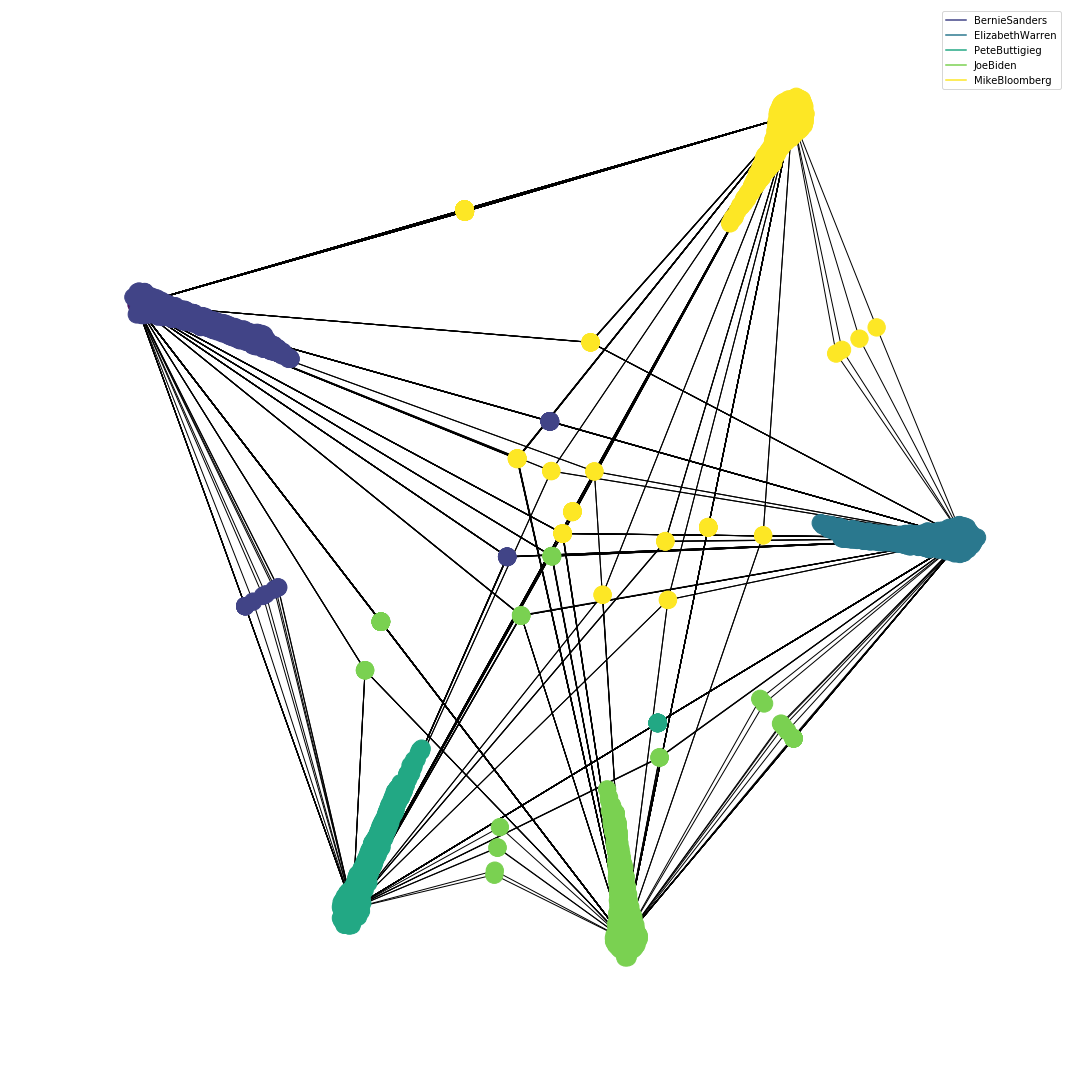

In [118]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
pos=nx.spring_layout(network_politican)
val_map_values = {'BernieSanders': 1,'ElizabethWarren': 2,'PeteButtigieg': 3,'JoeBiden': 4,'MikeBloomberg': 5}
# values = [val_map.get(node, 0) for node in network_politican.nodes()]
# Color mapping
jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1, figsize=(15, 15))
ax = f.add_subplot(1,1,1)
for label in val_map_values:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map_values[label]),
            label=label)

# Just fixed the color map
nx.draw_networkx(network_politican,pos, cmap = jet, vmin=0, vmax= max(values),
                 node_color=values,
                 with_labels=False,ax=ax)

# Here is were I get an error with your code                                                                                                                         
#nodes = nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)                                                                             

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')


f.tight_layout()
plt.show()

## Network for people tweeting about Warren

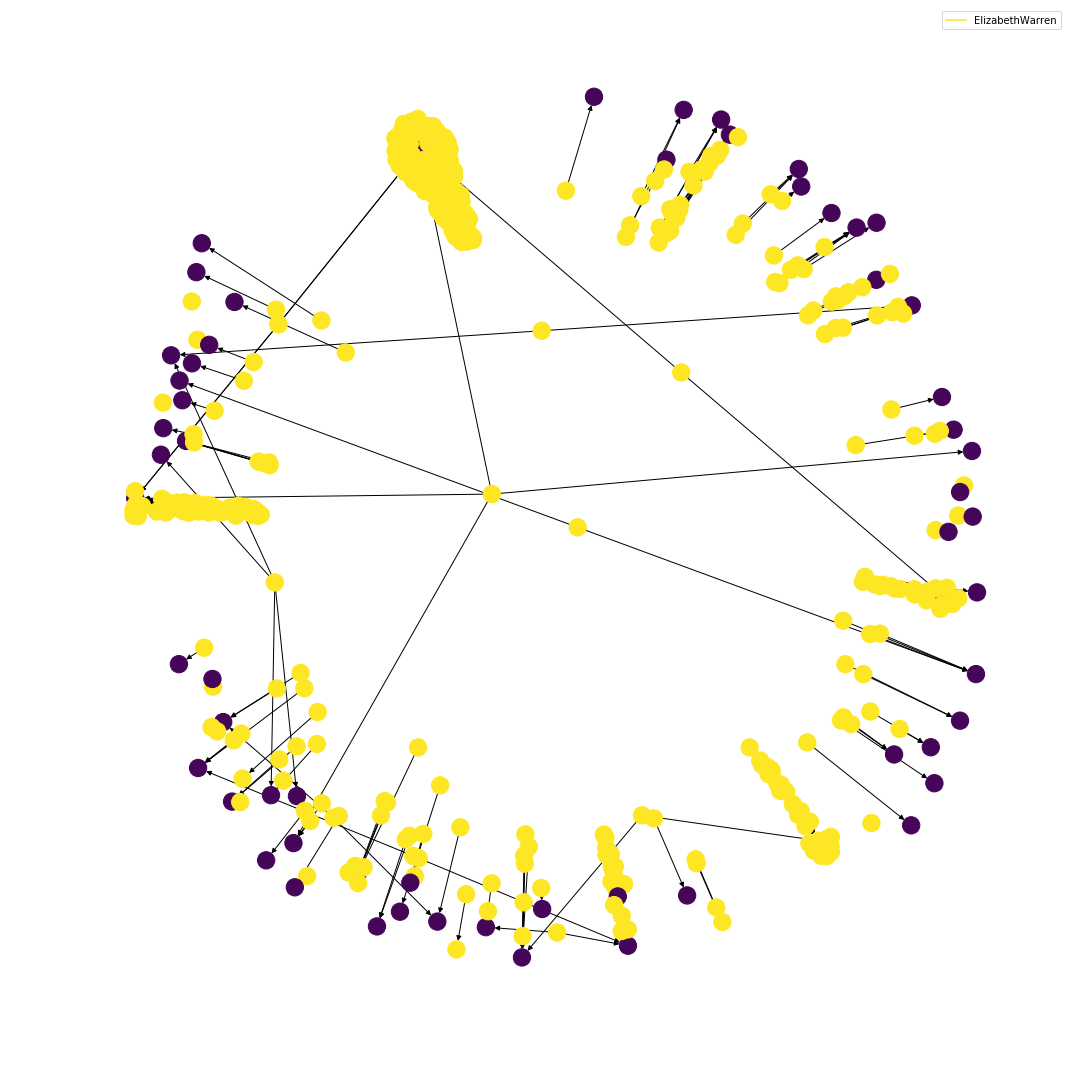

In [179]:
df_warren = df_total[df_total['politician'] == 'ElizabethWarren'] 

import matplotlib.colors as colors
import matplotlib.cm as cmx

# turn into network
network_politican = nx.from_pandas_edgelist(
    df_warren,
    source = 'user', 
    target = 'original_creator',
    create_using = nx.DiGraph())

def assign_candidate(tweet): 
    tweet = tweet.lower()
    if 'berniesanders'in tweet: 
        return 1
    if 'joebiden'in tweet: 
        return 4
    if 'mikebloomberg'in tweet: 
        return 5
    if 'petebuttigieg'in tweet: 
        return 3
    if 'elizabethwarren' in tweet: 
        return 20
    return 2


df_warren['value'] = df_warren['politician'].map(assign_candidate)
val_map = dict(zip(df_warren.user, df_warren.value))
values = [val_map.get(node, .25) for node in network_politican.nodes()]


import matplotlib.colors as colors
import matplotlib.cm as cmx
pos=nx.spring_layout(network_politican)
val_map_values = {'ElizabethWarren': 20}
# values = [val_map.get(node, 0) for node in network_politican.nodes()]
# Color mapping
jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1, figsize=(15, 15))
ax = f.add_subplot(1,1,1)
for label in val_map_values:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map_values[label]),
            label=label)

# Just fixed the color map
nx.draw_networkx(network_politican,pos, cmap = jet, vmin=0, vmax= max(values),
                 node_color=values,
                 with_labels=False,ax=ax)

# Here is were I get an error with your code                                                                                                                         
#nodes = nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)                                                                             

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')


f.tight_layout()
plt.show()

In [180]:
graph_centrality = nx.degree_centrality(network_politican)
sorted_cent = sorted(graph_centrality.items(), key=lambda x: x[1], reverse=True)
DataFrame(sorted_cent).head()

,0,1
0,mayawiley,0.345603
1,NancyLeeGrahn,0.112474
2,MillerCrime,0.057260
3,patte151,0.040900
4,diannemando,0.034765


## Network for people tweeting about Bernie

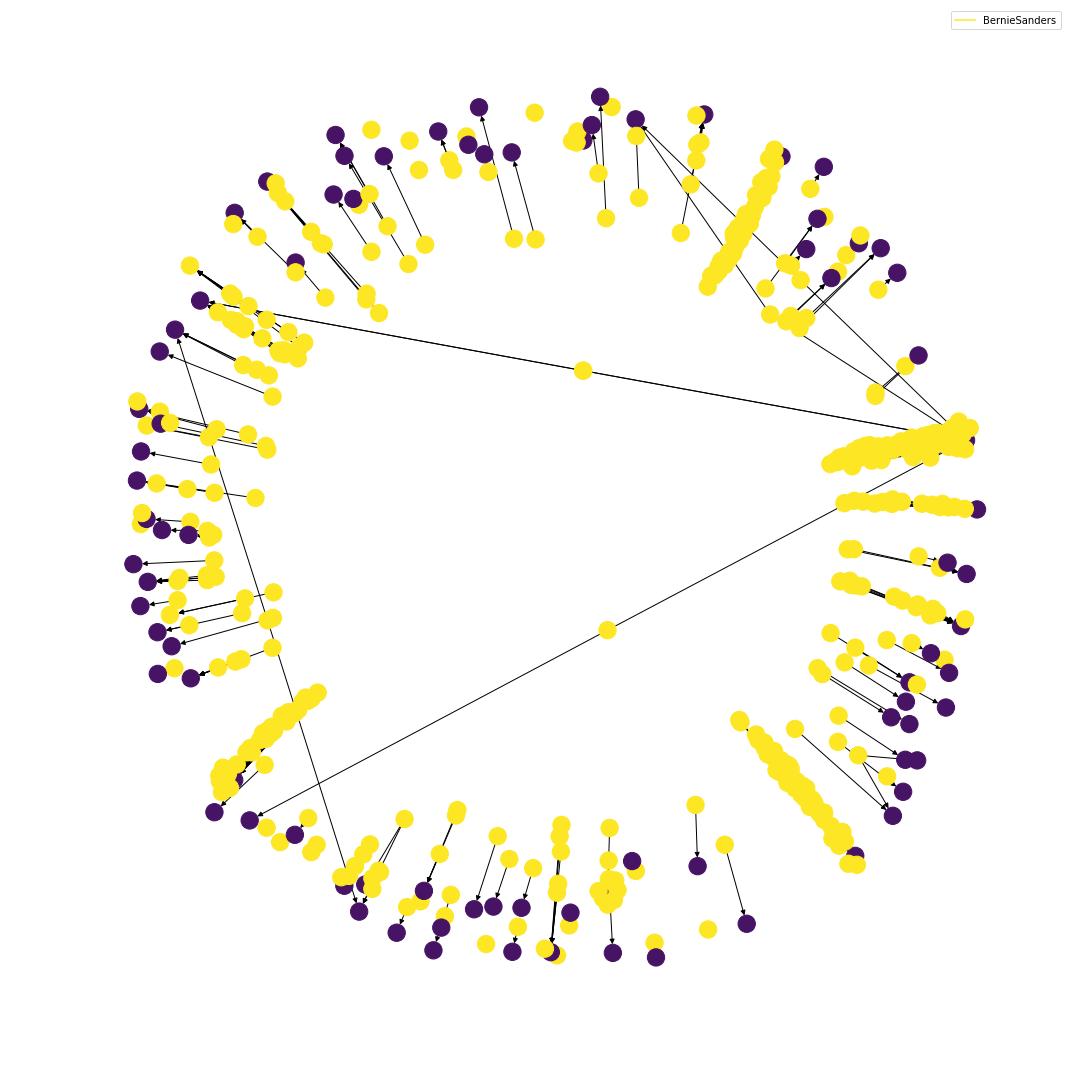

In [181]:
df_bernie = df_total[df_total['politician'] == 'BernieSanders'] 


# turn into network
network_politican = nx.from_pandas_edgelist(
    df_bernie,
    source = 'user', 
    target = 'original_creator',
    create_using = nx.DiGraph())

def assign_candidate(tweet): 
    tweet = tweet.lower()
    if 'berniesanders'in tweet: 
        return 10
    if 'joebiden'in tweet: 
        return 4
    if 'mikebloomberg'in tweet: 
        return 5
    if 'petebuttigieg'in tweet: 
        return 3
    if 'elizabethwarren' in tweet: 
        return 2
    return 2


df_bernie['value'] = df_bernie['politician'].map(assign_candidate)
val_map = dict(zip(df_bernie.user, df_bernie.value))
values = [val_map.get(node, .5) for node in network_politican.nodes()]


import matplotlib.colors as colors
import matplotlib.cm as cmx
pos=nx.spring_layout(network_politican)
val_map_values = {'BernieSanders': 10}
# values = [val_map.get(node, 0) for node in network_politican.nodes()]
# Color mapping
jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1, figsize=(15, 15))
ax = f.add_subplot(1,1,1)
for label in val_map_values:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map_values[label]),
            label=label)

# Just fixed the color map
nx.draw_networkx(network_politican,pos, cmap = jet, vmin=0, vmax= max(values),
                 node_color=values,
                 with_labels=False,ax=ax)

# Here is were I get an error with your code                                                                                                                         
#nodes = nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)                                                                             

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')


f.tight_layout()
plt.show()

In [182]:
graph_centrality = nx.degree_centrality(network_politican)
sorted_cent = sorted(graph_centrality.items(), key=lambda x: x[1], reverse=True)
DataFrame(sorted_cent).head()

,0,1
0,Vozable,0.142056
1,FIGHT_2_KAG,0.117757
2,benjaminwittes,0.089720
3,lindyli,0.063551
4,LostDiva,0.029907


## Network for people tweeting about Pete

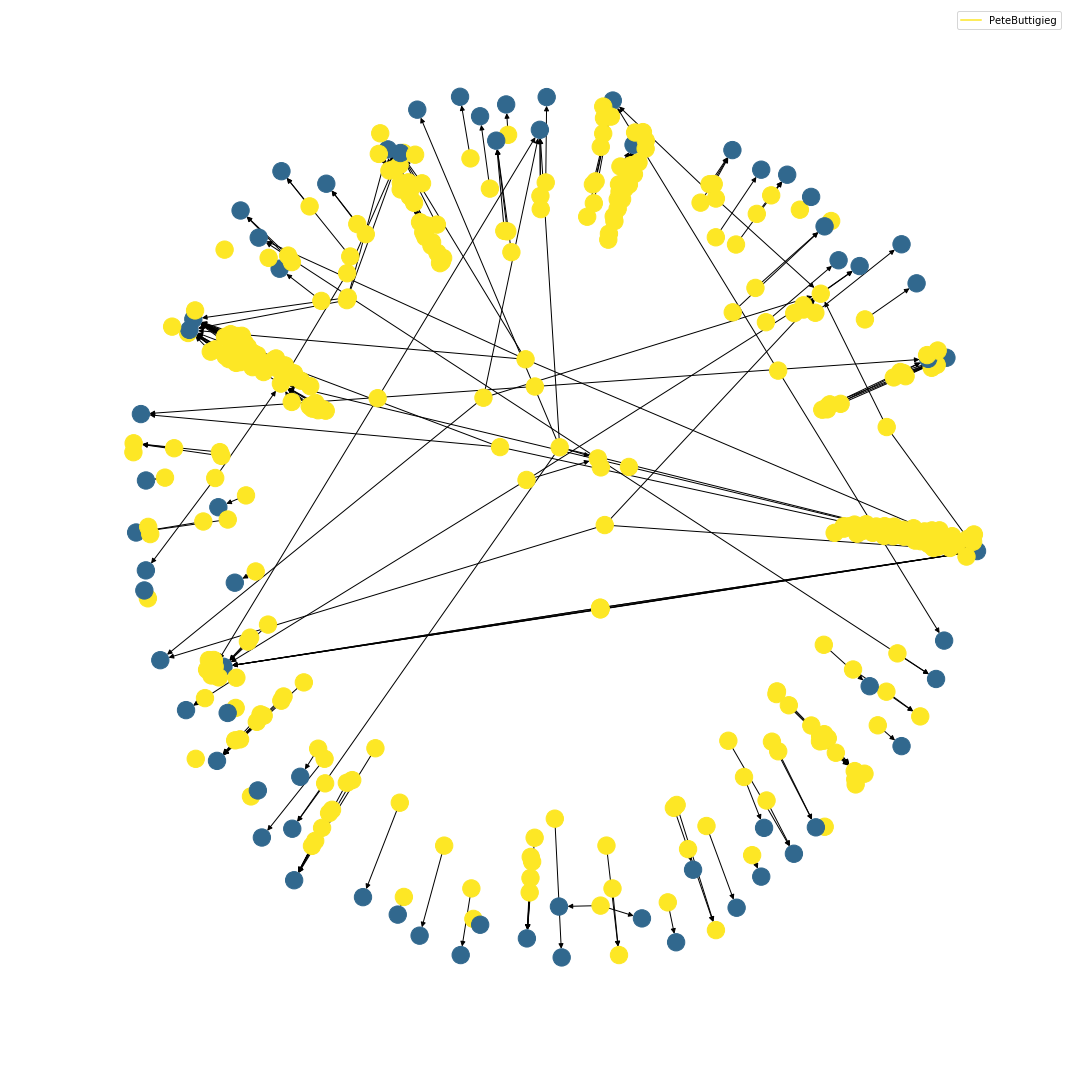

In [183]:
df_pete = df_total[df_total['politician'] == 'PeteButtigieg'] 


# turn into network
network_politican = nx.from_pandas_edgelist(
    df_pete,
    source = 'user', 
    target = 'original_creator',
    create_using = nx.DiGraph())

def assign_candidate(tweet): 
    tweet = tweet.lower()
    if 'berniesanders'in tweet: 
        return 1
    if 'joebiden'in tweet: 
        return 4
    if 'mikebloomberg'in tweet: 
        return 5
    if 'petebuttigieg'in tweet: 
        return 3
    if 'elizabethwarren' in tweet: 
        return 2
    return 2


df_pete['value'] = df_pete['politician'].map(assign_candidate)
val_map = dict(zip(df_pete.user, df_pete.value))
values = [val_map.get(node, 1) for node in network_politican.nodes()]


import matplotlib.colors as colors
import matplotlib.cm as cmx
pos=nx.spring_layout(network_politican)
val_map_values = {'PeteButtigieg': 3}
# values = [val_map.get(node, 0) for node in network_politican.nodes()]
# Color mapping
jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1, figsize=(15, 15))
ax = f.add_subplot(1,1,1)
for label in val_map_values:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map_values[label]),
            label=label)

# Just fixed the color map
nx.draw_networkx(network_politican,pos, cmap = jet, vmin=0, vmax= max(values),
                 node_color=values,
                 with_labels=False,ax=ax)

# Here is were I get an error with your code                                                                                                                         
#nodes = nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)                                                                             

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')


f.tight_layout()
plt.show()

In [184]:
graph_centrality = nx.degree_centrality(network_politican)
sorted_cent = sorted(graph_centrality.items(), key=lambda x: x[1], reverse=True)
DataFrame(sorted_cent).head()

,0,1
0,youcantbeatpete,0.158568
1,dragonian3333,0.079284
2,snowball1926,0.071611
3,kpnationalist19,0.056266
4,jfinn6511,0.038363


## Network for people tweeting about Bloomberg

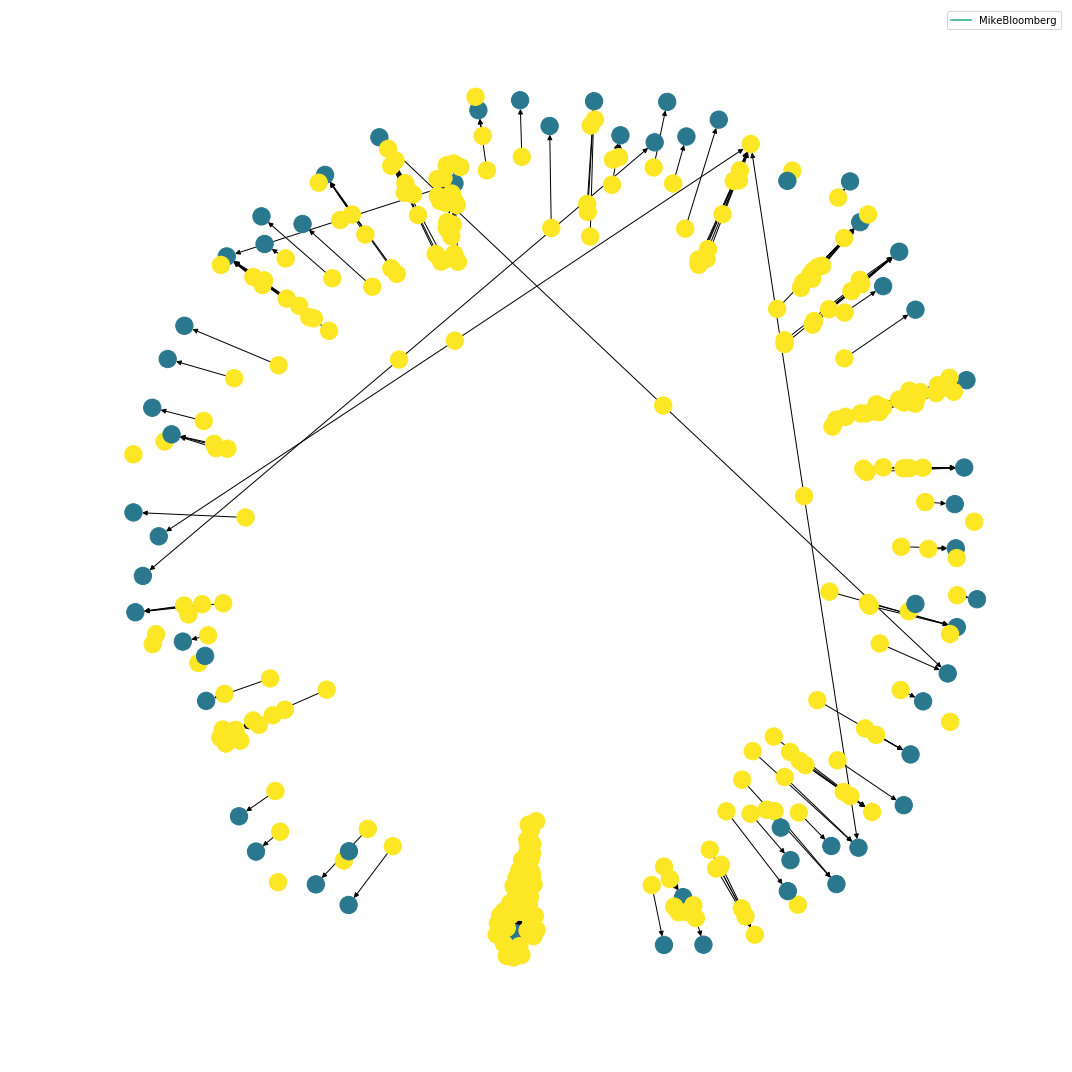

In [185]:
df_bloom = df_total[df_total['politician'] == 'MikeBloomberg'] 


# turn into network
network_politican = nx.from_pandas_edgelist(
    df_bloom,
    source = 'user', 
    target = 'original_creator',
    create_using = nx.DiGraph())

def assign_candidate(tweet): 
    tweet = tweet.lower()
    if 'berniesanders'in tweet: 
        return 1
    if 'joebiden'in tweet: 
        return 4
    if 'mikebloomberg'in tweet: 
        return 5
    if 'petebuttigieg'in tweet: 
        return 3
    if 'elizabethwarren' in tweet: 
        return 2
    return 2


df_bloom['value'] = df_bloom['politician'].map(assign_candidate)
val_map = dict(zip(df_bloom.user, df_bloom.value))
values = [val_map.get(node, 2) for node in network_politican.nodes()]


import matplotlib.colors as colors
import matplotlib.cm as cmx
pos=nx.spring_layout(network_politican)
val_map_values = {'MikeBloomberg': 3}
# values = [val_map.get(node, 0) for node in network_politican.nodes()]
# Color mapping
jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1, figsize=(15, 15))
ax = f.add_subplot(1,1,1)
for label in val_map_values:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map_values[label]),
            label=label)

# Just fixed the color map
nx.draw_networkx(network_politican,pos, cmap = jet, vmin=0, vmax= max(values),
                 node_color=values,
                 with_labels=False,ax=ax)

# Here is were I get an error with your code                                                                                                                         
#nodes = nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)                                                                             

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')


f.tight_layout()
plt.show()

In [186]:
graph_centrality = nx.degree_centrality(network_politican)
sorted_cent = sorted(graph_centrality.items(), key=lambda x: x[1], reverse=True)
DataFrame(sorted_cent).head()

,0,1
0,benjaminwittes,0.150943
1,JLPtalk,0.075472
2,KitOConnell,0.056604
3,trekkerteach12,0.040881
4,RzstProgramming,0.037736


## Network for people tweeting about Biden

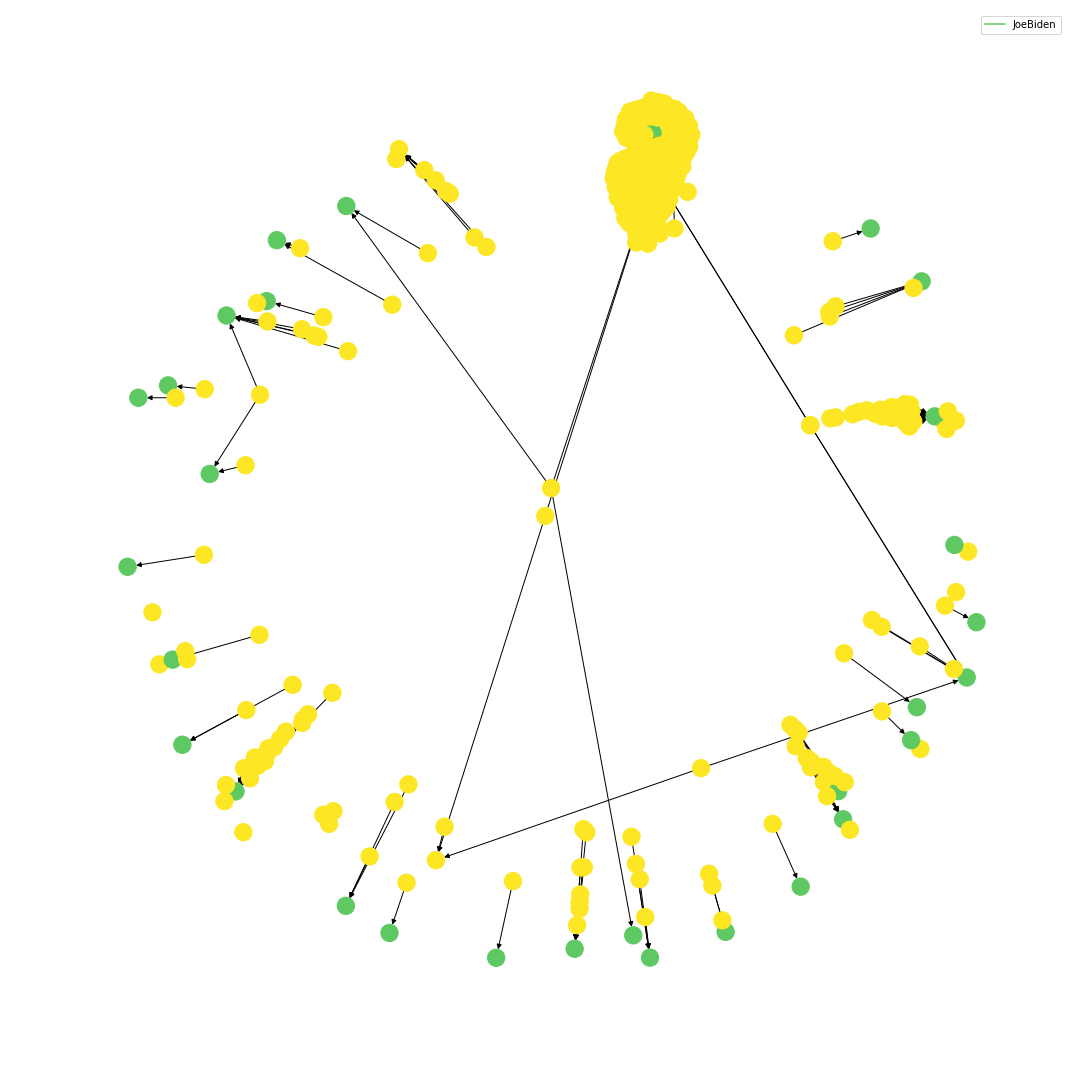

In [187]:
df_biden = df_total[df_total['politician'] == 'JoeBiden'] 


# turn into network
network_politican = nx.from_pandas_edgelist(
    df_biden,
    source = 'user', 
    target = 'original_creator',
    create_using = nx.DiGraph())

def assign_candidate(tweet): 
    tweet = tweet.lower()
    if 'berniesanders'in tweet: 
        return 1
    if 'joebiden'in tweet: 
        return 4
    if 'mikebloomberg'in tweet: 
        return 5
    if 'petebuttigieg'in tweet: 
        return 3
    if 'elizabethwarren' in tweet: 
        return 2
    return 2


df_biden['value'] = df_biden['politician'].map(assign_candidate)
val_map = dict(zip(df_biden.user, df_biden.value))
values = [val_map.get(node, 3) for node in network_politican.nodes()]


import matplotlib.colors as colors
import matplotlib.cm as cmx
pos=nx.spring_layout(network_politican)
val_map_values = {'JoeBiden': 3}
# values = [val_map.get(node, 0) for node in network_politican.nodes()]
# Color mapping
jet = cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1, figsize=(15, 15))
ax = f.add_subplot(1,1,1)
for label in val_map_values:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map_values[label]),
            label=label)

# Just fixed the color map
nx.draw_networkx(network_politican,pos, cmap = jet, vmin=0, vmax= max(values),
                 node_color=values,
                 with_labels=False,ax=ax)

# Here is were I get an error with your code                                                                                                                         
#nodes = nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)                                                                             

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='best')


f.tight_layout()
plt.show()

In [188]:
graph_centrality = nx.degree_centrality(network_politican)
sorted_cent = sorted(graph_centrality.items(), key=lambda x: x[1], reverse=True)
DataFrame(sorted_cent).head()

,0,1
0,ResisterSis20,0.401099
1,SallyDeal4,0.181319
2,JenPal4U,0.068681
3,KENNYBOO93,0.049451
4,jphoganorg,0.024725


# This is where my work ends

In [4]:
# t = df
# ori = t[t['original_creator'] == 'AAA']
# rt = t[t['original_creator'] != 'AAA']

# ori['original_creator'] = ori['user']
# ori_and_rt = ori.append(rt)

In [5]:
df2 = ori_and_rt.copy()
df2['original_creator'].nunique()

1315

In [6]:
degrees = df2['original_creator'].value_counts()[:200].index
def degree_filter(name): 
    if name in degrees: 
        return 1 
    return 0 

df2['degrees'] = df2['original_creator'].map(degree_filter)
df2 = df2[df2['degrees'] == 1]

Network Structure

In [110]:
import networkx as nx
# Create retweet network from edgelist
network = nx.from_pandas_edgelist(
    df2,
    source = 'user', 
    target = 'original_creator',
    create_using = nx.DiGraph())

In [111]:
def assign_candidate(tweet): 
    tweet = tweet.lower()
    if '#berniesanders'in tweet: 
        return 1.25
    if '#joebiden'in tweet: 
        return 1.0
    if '#mikebloomberg'in tweet: 
        return .75
    if '#petebuttigieg'in tweet: 
        return .5
    if '#elizabethwarren' in tweet: 
        return 1.25
    return 0.0

df2['value'] = df2['tweet'].map(assign_candidate)

In [112]:
def assign_candidate(tweet): 
    tweet = tweet.lower()
    if '#berniesanders'in tweet: 
        return 1.25
    if '#joebiden'in tweet: 
        return 1.0
    if '#mikebloomberg'in tweet: 
        return .75
    if '#petebuttigieg'in tweet: 
        return .5
    if '#elizabethwarren' in tweet: 
        return 1.25
    return 0.0

df2['value'] = df2['tweet'].map(assign_candidate)
val_map = dict(zip(df2.user, df2.value))
values = [val_map.get(node, .25) for node in network.nodes()]

In [113]:
val_map

{'LeftSideKrew': 1.25,
 'love_liberty100': 1.25,
 'FIGHT_2_KAG': 1.25,
 'NerdyHappy': 1.25,
 'turn_vote': 1.25,
 'priyadxe27': 1.25,
 'IDIOTdella': 1.25,
 'Primal_Digest': 1.25,
 'oyebee': 0.75,
 'TrumpKingofthe1': 1.25,
 'Beckstle': 1.25,
 'TheBigDsEgo': 1.25,
 'MimiTexasAngel': 0.5,
 'Meghan_BB_': 1.0,
 'RedRedGreen': 0.75,
 'MHayehudi': 0.5,
 'gangstermiles': 1.25,
 'KristineCummins': 1.25,
 'TheWashingtonRT': 1.25,
 'judymorris3': 1.25,
 'CyrusShares': 1.25,
 'Jamie_Margolin': 1.25,
 'AmyCMcintosh': 0.0,
 'WhartonDj': 1.25,
 'BHPanimalwatch': 1.25,
 'SharonCarbine': 0.0,
 'mobygrapefan': 1.25,
 'WestJournalism': 1.25,
 'LostDiva': 1.25,
 'AdreanaInLB': 1.25,
 'KENNYBOO93': 0.0,
 'patrickcurl': 0.75,
 'CorporatePiggie': 0.75,
 'EricJafMN': 0.75,
 'Americasian1': 1.0,
 'MaQualeSantone': 1.0,
 'SallyDeal4': 0.0,
 'steinhauserNH1': 1.25,
 'dailysoundnfury': 1.25,
 'VirginiaBloom9': 1.0,
 'ResisterSis20': 1.0,
 'ForIAmKing78': 1.0,
 'MoLulkowski': 0.0,
 'patte151': 1.25,
 'iloanya1': 1.

In [10]:
print('Nodes in RT network:', len(network.nodes()))
print('Edges in RT network:', len(network.edges()))

Nodes in RT network: 2748
Edges in RT network: 2919


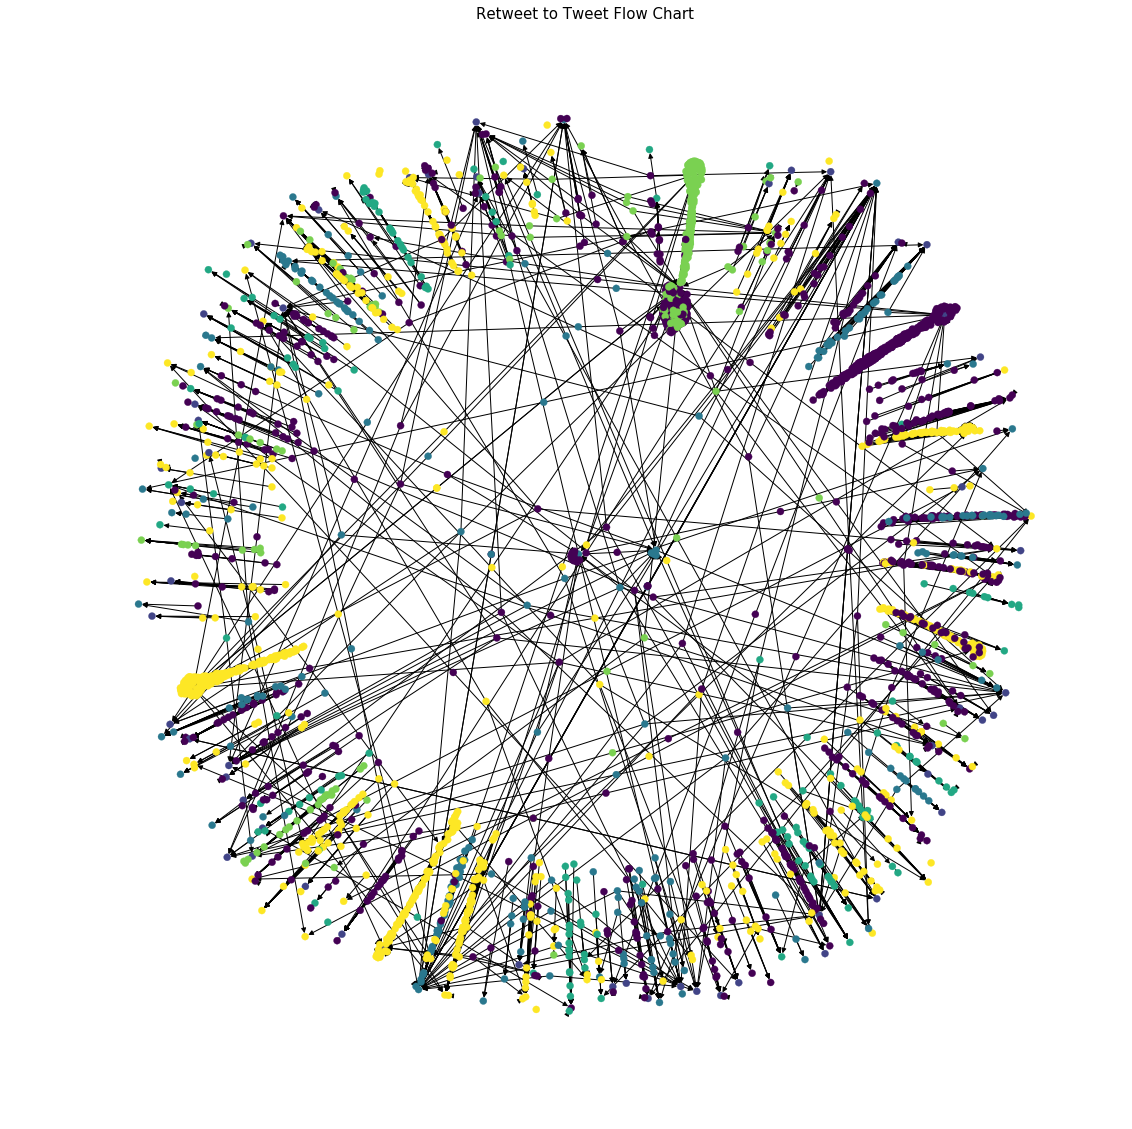

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
nx.draw(network, edge_color ="black", linewidths=0.3, node_size=50, cmap=plt.get_cmap('viridis'),node_color=values)
plt.title('Retweet to Tweet Flow Chart', size=15)
plt.show()

In [ ]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition
 
# To begin the parallel computation, we initialize a Pool object with the
# number of available processors on our hardware. We then partition the
# network based on the size of the Pool object (the size is equal to the 
# number of available processors). 
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    #Next, we pass each processor a copy of the entire network and 
    #compute #the betweenness centrality for each vertex assigned to the 
    #processor.
 
    bet_map = p.map(btwn_pool,
                    zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    #Finally, we collect the betweenness centrality calculations from each 
    #pool and aggregate them together to compute the overall betweenness 
    #centrality score for each vertex in the network.
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

Network Centrality, closeness, and betweeness

In [250]:
graph_centrality = nx.degree_centrality(network)
sorted_cent = sorted(graph_centrality.items(), key=lambda x: x[1], reverse=True)
DataFrame(sorted_cent).head()

,0,1
0,SallyDeal4,0.107586
1,larryelder,0.096280
2,mayawiley,0.061634
3,ResisterSis20,0.053975
4,FIGHT_2_KAG,0.029905


In [251]:
graph_closeness = nx.closeness_centrality(network)
sorted_closeness = sorted(graph_closeness.items(), key=lambda x: x[1], reverse=True)
DataFrame(sorted_closeness).head()

,0,1
0,SallyDeal4,0.106511
1,larryelder,0.096280
2,ResisterSis20,0.093567
3,mayawiley,0.061634
4,FIGHT_2_KAG,0.029176


In [252]:
graph_betweenness = nx.betweenness_centrality(network, normalized=True, endpoints=False)
sorted_bet=sorted(graph_betweenness.items(), key=lambda x: x[1], reverse=True)[:50]

In [253]:
df2['closeness'] = df['original_creator'].map(graph_closeness)
df2['centrality'] = df['original_creator'].map(graph_centrality)
df2['betweeness']=df['original_creator'].map(graph_betweenness)


In [254]:
df2.sort_values(by = 'betweeness').head()

,Unnamed: 0,user,location,tweet,created_at,original_creator,retweet,value,degrees,closeness,centrality,betweeness
0,0,TeamKAG2020,America,"Okay, this says it all. For all you #BernieSa...",2020-02-19 22:25:39,FIGHT_2_KAG,1,1.25,1,0.029176,0.029905,0.0
3166,277,CountryMamaRose,NaN,#PeteButtigieg doesn't get the news coverage ...,2020-02-19 19:18:21,youcantbeatpete,1,0.50,1,0.022611,0.023341,0.0
3167,278,KelseyM53339643,NaN,Out of the candidates out there Mayor Pete is...,2020-02-19 19:17:59,christo37105031,1,0.00,1,0.007182,0.004376,0.0
3168,279,RTerriers,Flyovercountry,"""South Bend residents warn 'inept' Buttigieg ...",2020-02-19 19:17:21,snowball1926,1,0.50,1,0.010212,0.010941,0.0
3169,280,GryphonsRAWK,"Chicago, IL","""South Bend residents warn 'inept' Buttigieg ...",2020-02-19 19:16:52,snowball1926,1,0.50,1,0.010212,0.010941,0.0


In [255]:
a_list = []
for x in range(0,len(sorted_bet)): 
    b = str(sorted_cent[x][0])
    a_list.append(b)

In [256]:
def v(name): 
    if name in a_list: 
        return 1 
    return 0 

one_two = df['original_creator'].map(v)
df['top_50'] = one_two
top = df[df['top_50'] == 1]

In [258]:
non_duplicates = df2['original_creator'].value_counts()
df3=df2[df2['original_creator'].isin(non_duplicates[non_duplicates].index)]

IndexError: index 335 is out of bounds for axis 0 with size 200

In [ ]:
# Create retweet network from edgelist
G_rt1 = nx.from_pandas_edgelist(
    df3,
    source = 'user', 
    target = 'original_creator',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in RT network:', len(G_rt1.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt1.edges()))

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
nx.draw(G_rt1, node_color="red", cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
plt.title('Retweet to Tweet Flow Chart', size=20)
plt.show()